In [30]:
%load_ext autoreload
%autoreload 2


import torch

from sampling.sampling import sample_on_sphere_uniform, sample_conditional
from data.generation import SphereDecoder
from data.encoder import SphereEncoder

import matplotlib.pyplot as plt

Maximum squared norm: tensor(1.0000, grad_fn=<MaxBackward1>)
Minimum squared norm: tensor(1.0000, grad_fn=<MinBackward1>)


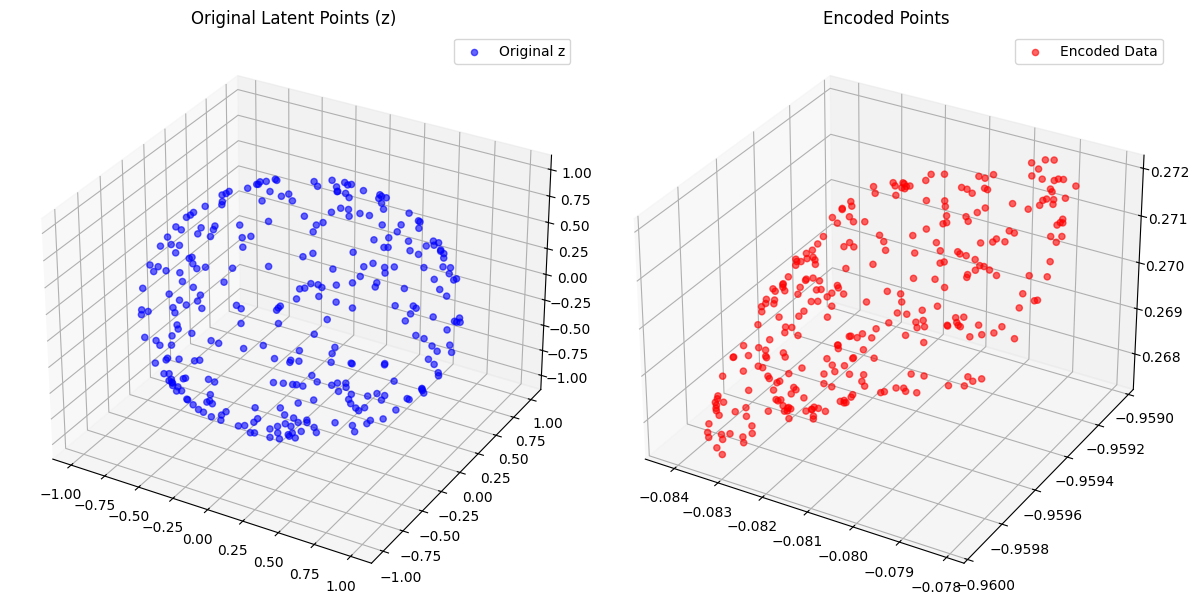

In [31]:
# Setting up the initial experiment

latent_dimension = 3
output_dimension = 100
number_of_samples = 300

generation_process = SphereDecoder(latent_dimension, output_dimension)
encoder = SphereEncoder(output_dimension, latent_dimension)

z = sample_on_sphere_uniform(number_of_samples, latent_dimension)
decoded_data = generation_process(z)

encoded_data = encoder(decoded_data)

# Sanity checks
print('Maximum squared norm:', (encoded_data ** 2).sum(dim=1).max())
print('Minimum squared norm:', (encoded_data ** 2).sum(dim=1).min())

z_3d = z[:, :3].detach().numpy()
encoded_data_3d = encoded_data[:, :3].detach().numpy()

# Plot in 3D
fig = plt.figure(figsize=(12, 6))

# Original points
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(z_3d[:, 0], z_3d[:, 1], z_3d[:, 2], c='b', label='Original z', alpha=0.6)
ax1.set_title('Original Latent Points (z)')
ax1.legend()

# Encoded points
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(encoded_data_3d[:, 0], encoded_data_3d[:, 1], encoded_data_3d[:, 2], c='r', label='Encoded Data', alpha=0.6)
ax2.set_title('Encoded Points')
ax2.legend()

plt.tight_layout()
plt.show()

Maximum squared norm (Original): 1.000000238418579
Minimum squared norm (Original): 0.9999998211860657
Maximum squared norm (Encoded Augmented): 1.0000001192092896
Minimum squared norm (Encoded Augmented): 0.9999998211860657


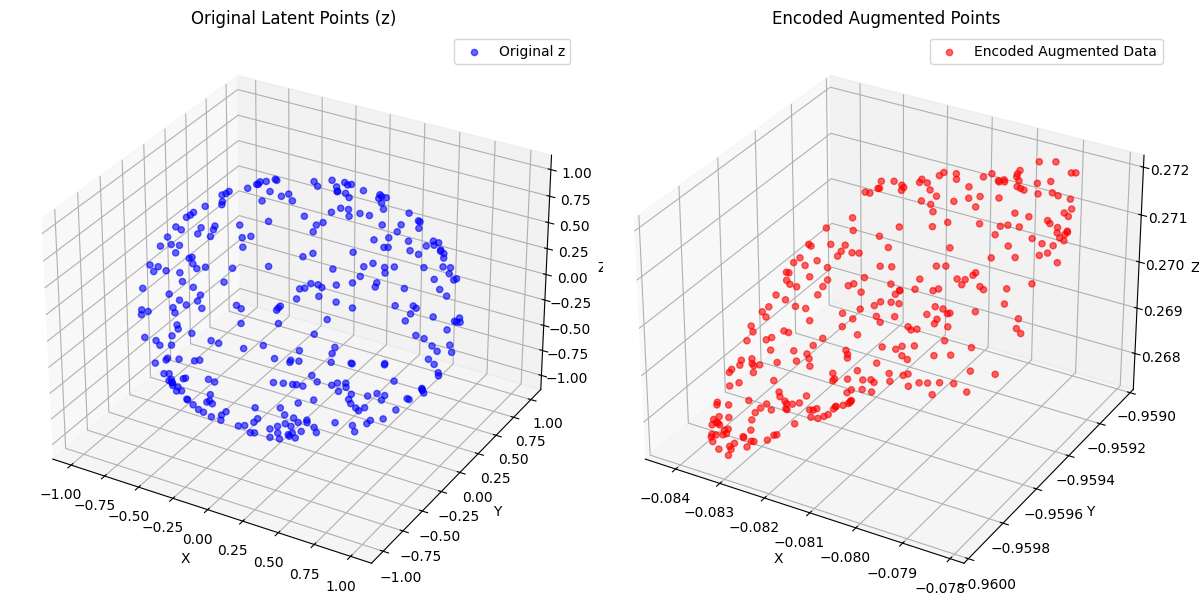

In [32]:
kappa_1 = 0.1
d_fixed = 0 # Initial experiment will allow variation in all dimensions

# Generate augmented latents (ensure `sample_conditional` is defined)
augmented_z = sample_conditional(z, kappa_1, d_fixed)

decoded_augmented_data = generation_process(augmented_z)

encoded_augmented_data = encoder(decoded_augmented_data)

# Sanity checks for augmented and encoded data
print('Maximum squared norm (Original):', (z ** 2).sum(dim=1).max().item())
print('Minimum squared norm (Original):', (z ** 2).sum(dim=1).min().item())
print('Maximum squared norm (Encoded Augmented):', (encoded_augmented_data ** 2).sum(dim=1).max().item())
print('Minimum squared norm (Encoded Augmented):', (encoded_augmented_data ** 2).sum(dim=1).min().item())

# Convert tensors to NumPy arrays for visualization
z_3d = z[:, :3].detach().numpy()  # Original latent points
encoded_augmented_data_3d = encoded_augmented_data[:, :3].detach().numpy()  # Encoded augmented points

# Plot in 3D
fig = plt.figure(figsize=(12, 6))

# Original latent points
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(z_3d[:, 0], z_3d[:, 1], z_3d[:, 2], c='b', label='Original z', alpha=0.6)
ax1.set_title('Original Latent Points (z)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.legend()

# Encoded augmented latent points
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(
    encoded_augmented_data_3d[:, 0],
    encoded_augmented_data_3d[:, 1],
    encoded_augmented_data_3d[:, 2],
    c='r',
    label='Encoded Augmented Data',
    alpha=0.6,
)
ax2.set_title('Encoded Augmented Points')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Training Optimal Encoder

In this part of the experiment you need to train an optimal encoder using the SimCLR framework. The goal is to get it to reconstruct a sphere in a setting where all dimensions are allowed to vary.

From the paper, they give the following recipie given $2N$ samples: $N$ original samples + $N$ augmentations:

1. $s_{i,j} := z_{i}^{T}z_{j} \ \forall i,j \in \{1,...,2N\}$ (Here we won't normalize, because the vecors are already on the unit sphere)
2. $l(i,j) := -log(\frac{exp(s_{i,j}/\tau)}{\Sigma_{k=1}^{2N} \mathbb{1}_{[k \neq i}]exp(s_{i,k}/\tau)})$
3. $\mathcal{L} := \frac{1}{2N} \Sigma_{k=1}^{N} l(2k-1,2k) + l(2k,2k-1)$

Here one thing I have omitted was that in their framework $z_{2k} \sim z_{2k-1}$

In this implementation we will use $z_{k} \sim z_{N + k}$

https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

To get a similarity matrix of dot products of vectors, we can simply define $A := [z^{T}, \tilde{z}]^{T} \in \mathbb{R}^{2N \times 3}$ - a matrix that holds all vectors, and compute the resulting similarity matrix $S = AA^{T}$ using the matrix product.

$S_{i,j} = \Sigma_{k=1}^{3}A_{i,k}A^{T}_{k,j} = \Sigma_{k=1}^{3}A_{i,k}A_{j,k} = A_{i,1}A_{j,1} + A_{i,2}A_{j,2} + A_{i,3}A_{j,3} = z_{i,1}z_{j,1} + z_{i,2}z_{j,2} + z_{i,3}z_{j,3} = z_{i}^{T}z_{j}$

## On loss implementation

torch.nn.CrossEntropy for 1 sample takes in a vector of dimension $C$, and a class c, outputs $-log(\frac{exp(x_{c})}{\Sigma_{k=1}^{C}exp(x_{k})})$

What we need to do here is to first, mask the diagonal with $-\infty$, since we want the denominator to vanish out with exp(-inf) on the self-similarity term. On the numerator term, I want to take the indices in the following order: (2,1), (1,2), (3,4), (4,3), (5,6), (6,5), etc. (from the paper).

The implementation:

1. Compute similarity matrix
2. Mask the diagonal
3. Compute the labels by first doing arrange from 0,..,2N-1, then swap every 2 entries

In [34]:
# Using SimCLR framework to find an optimal encoder

from simclr.simclr import SimCLR

sim_clr = SimCLR(encoder, z, augmented_z)
sim_clr.fit()

AttributeError: 'SimCLR' object has no attribute 'fit'